EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 4.9629e-01 | 1.0000e+00 |       50312 |      101376 |         1024 |        1024 |         6.8 |reached target block errors
   -2.429 | 4.9379e-01 | 1.0000e+00 |       50058 |      101376 |         1024 |        1024 |         6.8 |reached target block errors
   -1.857 | 4.9253e-01 | 1.0000e+00 |       49931 |      101376 |         1024 |        1024 |         6.8 |reached target block errors
   -1.286 | 4.9055e-01 | 1.0000e+00 |       49730 |      101376 |         1024 |        1024 |         6.7 |reached target block errors
   -0.714 | 4.9196e-01 | 1.0000e+00 |       49873 |      101376 |         1024 |        1024 |         6.6 |reached target block errors
   -0.143 | 4.8962e-01 | 1.0000e+00 |       49636 |      101376 |

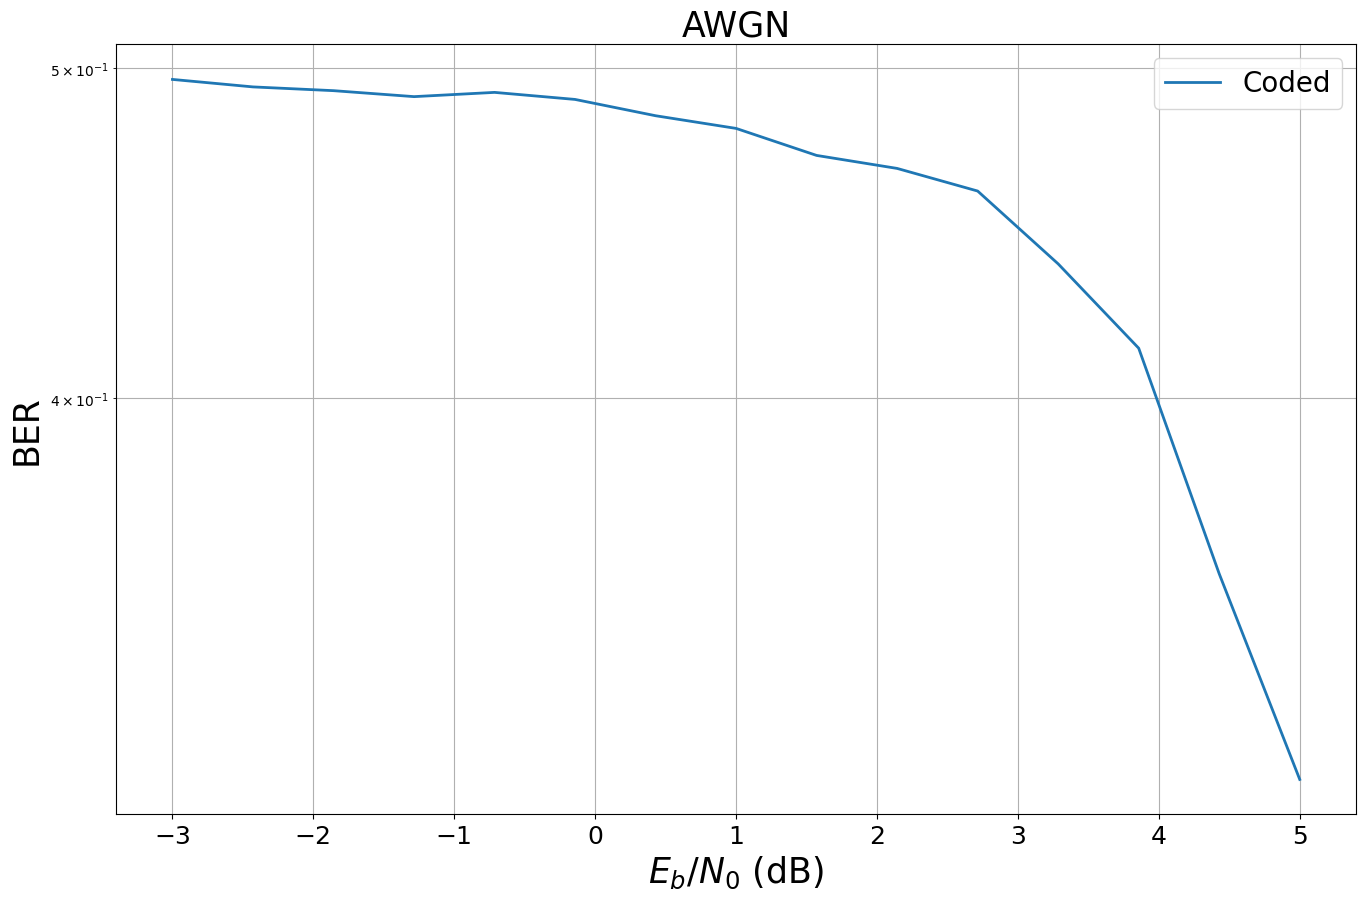

In [2]:
'''
TASK:
Simulate the coded bit error rate (BER) for a Polar coded and 64-QAM modulation.
Assume a codeword length of n = 200 and coderate = 0.5.

Hint: For Polar codes, successive cancellation list decoding (SCL) gives the 
best BER performance. However, successive cancellation (SC) decoding 
(without a list) is less complex.
'''

import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import sionna.phy
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf

class CodedSystemAWGN(sionna.phy.Block):
    def __init__(self, num_bits_per_symbol, n, coderate):
        super().__init__() # Must call the Sionna block initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sionna.phy.mapping.Constellation("qam", self.num_bits_per_symbol)

        self.mapper = sionna.phy.mapping.Mapper(constellation=self.constellation)
        self.demapper = sionna.phy.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sionna.phy.mapping.BinarySource()
        self.awgn_channel = sionna.phy.channel.AWGN()

        self.encoder = sionna.phy.fec.polar.Polar5GEncoder(self.k, self.n)
        self.decoder = sionna.phy.fec.polar.Polar5GDecoder(self.encoder, hard_out=True, dec_type = "SCL")

    #@tf.function # activate graph execution to speed things up
    def call(self, batch_size, ebno_db):
        no = sionna.phy.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel(x, no)
        llr = self.demapper(y,no)
        bits_hat = self.decoder(llr)
        return bits, bits_hat

def main():
    CODERATE = 0.5
    NUM_BITS_PER_SYMBOL = 6 #64QAM Modulation
    EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
    EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations
    BATCH_SIZE = 1024 # How many examples are processed by Sionna in parallel

    model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                   n=198,
                                   coderate=CODERATE)
    
    ber_plots = sionna.phy.utils.PlotBER("AWGN")

    ber_plots.simulate(model_coded_awgn,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 15),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=500,
                   legend="Coded",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False)

main()

